In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00


# Predicción de precio de azúcar

In [2]:
## Se importan librerías

#Librerías para importación de base desde drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Librerias para análisis de series de tiempo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf
import pmdarima as pm


In [3]:
# Mount Google Drive
drive.mount('/content/drive')


# Construct the file path using the file ID obtained from the link
#file_id = '1Y9FxKfm21Aw1Omm8FJ2t8rWBvUKfmwoH'  # actual file ID
file_path = '/content/drive/MyDrive/DATASETS_ML/sugar_price_daily.csv'#.format(file_id)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
print(df.head())

Mounted at /content/drive
         Date       Open       High        Low      Close  Adj Close  Volume
0  2017-01-03  19.629999  20.549999  19.580000  20.510000  20.510000   73926
1  2017-01-04  20.549999  20.940001  20.410000  20.889999  20.889999   58526
2  2017-01-05  20.889999  21.180000  20.660000  20.780001  20.780001   65318
3  2017-01-06  20.660000  20.840000  20.299999  20.750000  20.750000   46344
4  2017-01-09  20.740000  20.750000  20.360001  20.420000  20.420000   52101


In [4]:
#Selecting date and closed price
df_cierre = df[['Date', 'Close']]

df_cierre = df_cierre.set_index('Date')
df_cierre.index = pd.to_datetime(df_cierre.index)


In [5]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [6]:
monthly_price = df_cierre.resample('M').mean()
print(monthly_price)

                Close
Date                 
2017-01-31  20.537500
2017-02-28  20.405789
2017-03-31  18.059565
2017-04-30  16.316842
2017-05-31  15.689091
...               ...
2023-12-31  22.222000
2024-01-31  22.606191
2024-02-29  23.355000
2024-03-31  21.731500
2024-04-30  20.691905

[88 rows x 1 columns]


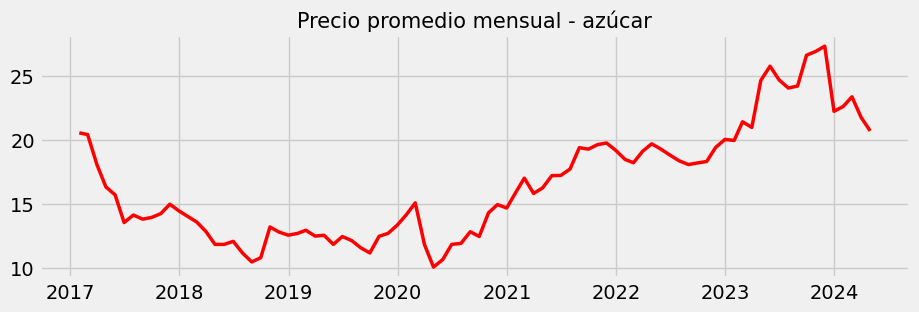

In [7]:
#Visualización de serie de tiempo
plt.figure(figsize=(10,3))
plt.plot(monthly_price,lw=2.5, color="r",)
plt.title("Precio promedio mensual - azúcar", fontsize=15);

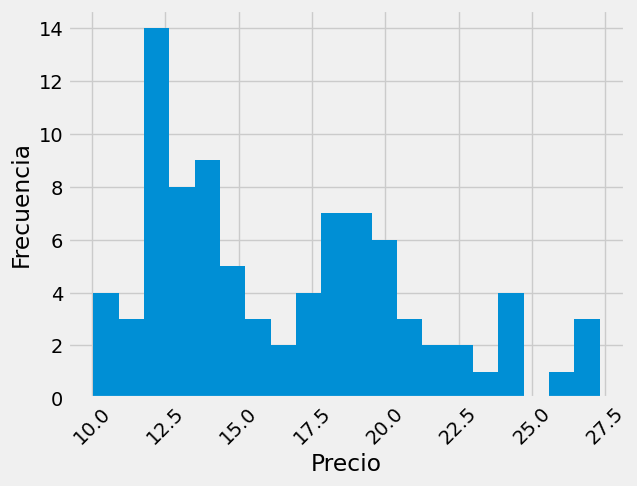

In [8]:
### Histograma del precio medio del azúcar
plt.hist(monthly_price['Close'], bins=20)
plt.xlabel('Precio')
plt.xticks(rotation=45)
plt.ylabel('Frecuencia')
plt.show()

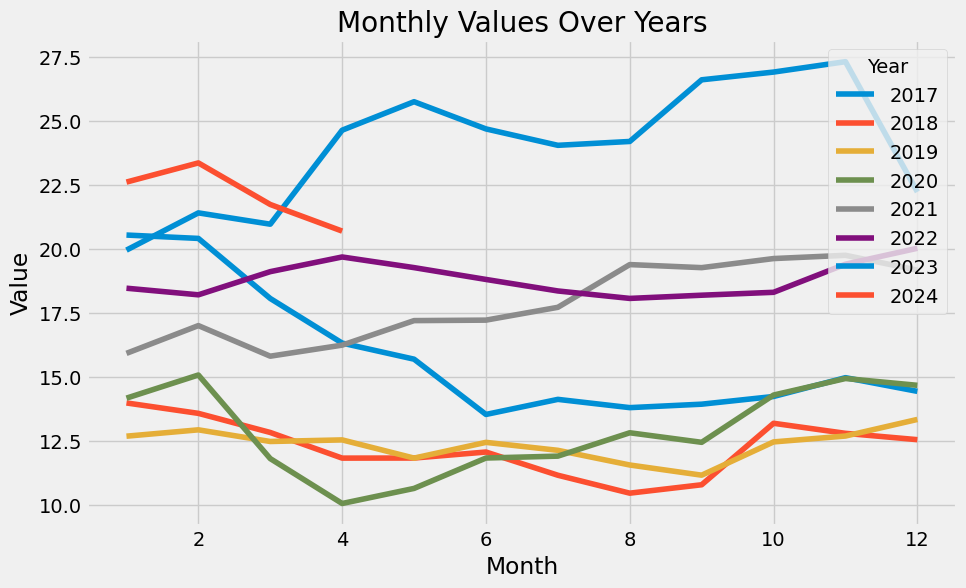

In [9]:
#Gráfico por año de precio de azúcar

monthly_price_copy = monthly_price
years = monthly_price_copy.index.year.unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Iterate over years and plot each year's data as a separate line
for year in years:
    data_year = monthly_price_copy[monthly_price_copy.index.year == year]
    plt.plot(data_year.index.month, data_year['Close'], label=str(year))

# Add labels and legend
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Monthly Values Over Years')
plt.legend(title='Year', loc='upper right')

# Show plot
plt.show()

In [10]:
print(monthly_price.describe())

           Close
count  88.000000
mean   16.556630
std     4.420750
min    10.051905
25%    12.685488
50%    15.747371
75%    19.454047
max    27.309546


Del 2017 al 2023, el precio promedio ha sido de 16.5 USD

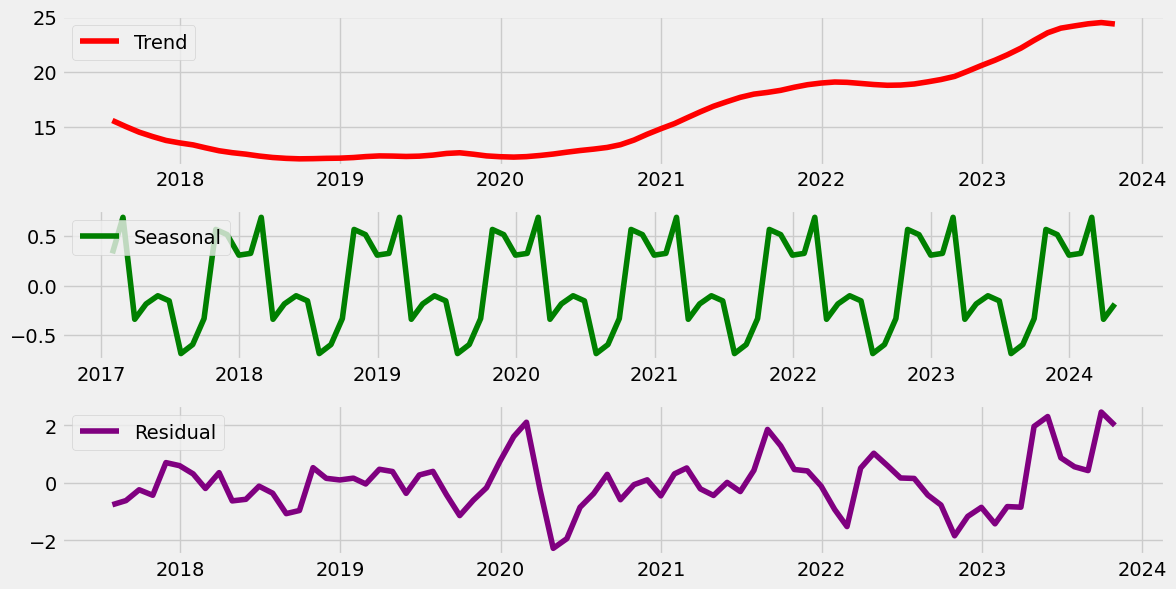

In [11]:
#Descomposición de serie de tiempo

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(monthly_price['Close'], model='additive')
# Plot the decomposed components
plt.figure(figsize=(12, 8))
#plt.subplot(411)
#plt.plot(df['Close'], label='Original', color='blue')
#plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

##### Se destaca una tendencia creciente de la serie a partir del año 2020 en adelante, con una ligera suavización en la ultima parte del 2024 según la información disponible hasta abril.

##### La componente estacional muestra que desde inicios de marzo hasta agosto se tiene una caida y de agosto a febero los precios suelen sumentar.

##### Se procede a aplicar un modelo SARIMA dado que se tiene presente tendencia y estacionalidad.

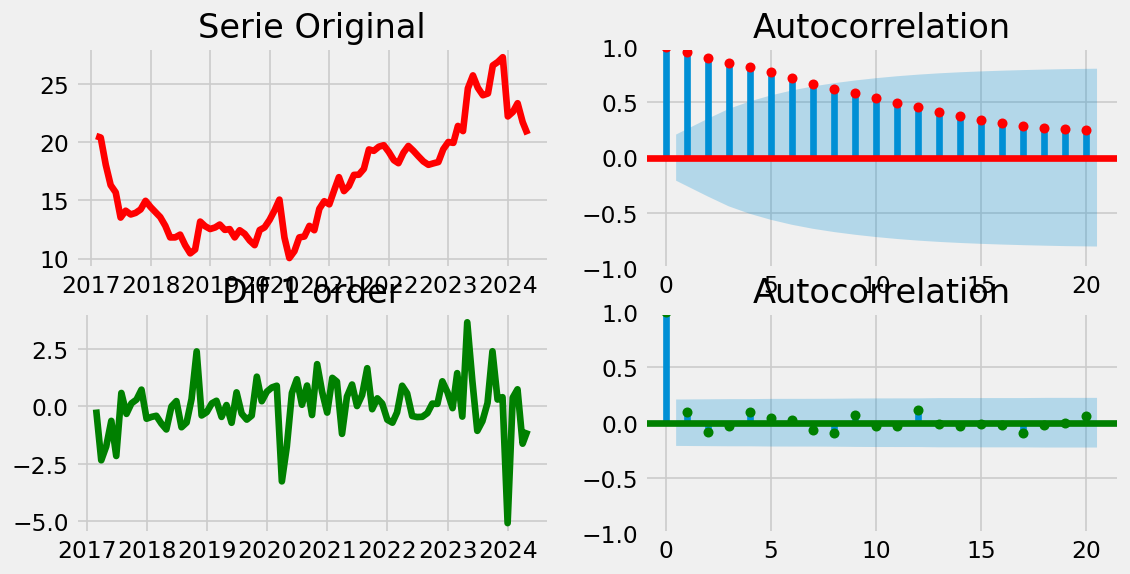

In [12]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
# Serie Original
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(monthly_price,color="r"); axes[0, 0].set_title('Serie Original')
plot_acf(monthly_price, ax=axes[0, 1], color="r")

# Primera diferenciación
axes[1, 0].plot(monthly_price.diff(), color="g"); axes[1, 0].set_title("Dif 1 order")
plot_acf(monthly_price.diff().dropna(), ax=axes[1, 1],color="g")

plt.show();

##### Con una diferenciación se obtuvo a la vista una serie estacionaria. Se procede a determinar por medio del test de Dicky Fuller si efectivamente, asignando D=1 la serie es estacionaria.

In [13]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

Augmented_Dickey_Fuller_Test_func(monthly_price.diff().dropna(),"Close")

Resultados de la prueba de Dickey-Fuller para columna: Close
Test Statistic                       -6.782280e+00
p-value                               2.482010e-09
No Lags Used                          1.000000e+00
Número de observaciones utilizadas    8.500000e+01
Critical Value (1%)                  -3.509736e+00
Critical Value (5%)                  -2.896195e+00
Critical Value (10%)                 -2.585258e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


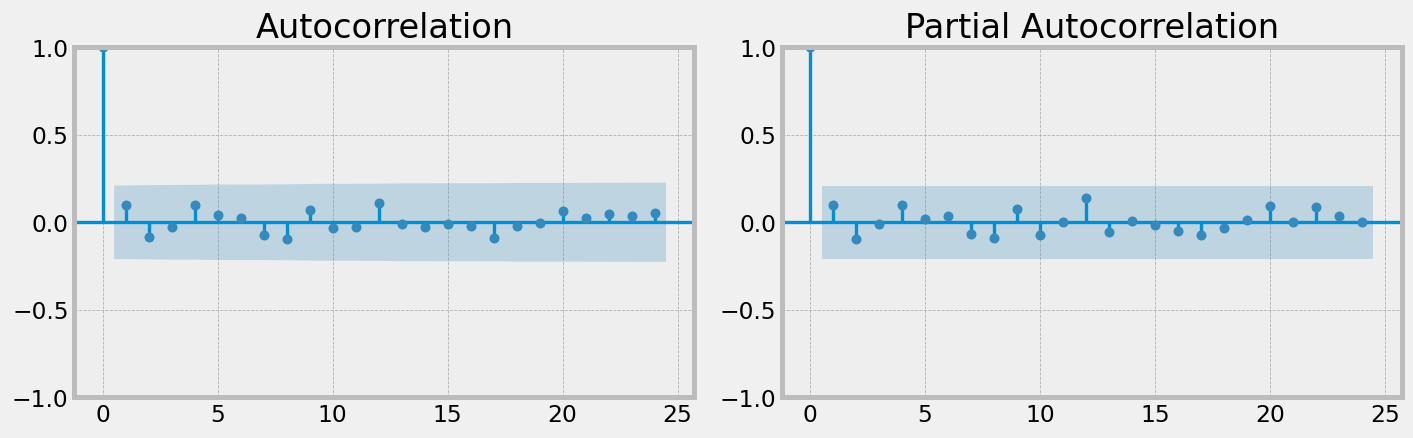

In [14]:
### Cálculo de componente AR y MA

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        #ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        #y.plot(ax=ts_ax)
        #p_value = sm.tsa.stattools.adfuller(y)[1]
        #ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(monthly_price["Close"].diff().dropna(), lags=24);

##### Tomando en cuenta los gráficos de ACF (correlación de la serie consigo misma pero corrida un tiempo t) y PACF (correlación entre una serie de tiempo con su versión rezagada, quitando el efecto de la correlación de rezagos más pequeños) para determinar los valores de MA y AR, respectivamente, ninguno de los valores sobrepasan el umbral, por lo que asignaremos 0 a ambas componentes.

In [15]:
# 0,1,0 ARIMA Model
model1 = ARIMA(monthly_price["Close"], order=(0,1,0))
model_fit1 = model1.fit()
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                   88
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -136.685
Date:                Mon, 06 May 2024   AIC                            275.371
Time:                        16:46:48   BIC                            277.837
Sample:                    01-31-2017   HQIC                           276.364
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.3557      0.116     11.657      0.000       1.128       1.584
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                74.26
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.78
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Seasonal - fit stepwise auto-ARIMA
smodel1 = pm.auto_arima(monthly_price, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel1.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=292.983, Time=0.26 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=302.055, Time=0.07 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=288.576, Time=0.20 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=258.275, Time=0.40 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=272.204, Time=0.15 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=260.174, Time=0.66 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=260.166, Time=0.52 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=264.633, Time=0.15 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=262.160, Time=0.97 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=259.785, Time=0.35 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=259.717, Time=0.30 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=281.111, Time=0.22 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=261.702, Time=0.48 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.78 sec

Best model:  ARIMA(0,2,1)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   88
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -126.138
Date:                            Mon, 06 May 2024   AIC                            258.275
Time:                                    16:47:09   BIC                            265.187
Sample:                                01-31-2017   HQIC                           261.032
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9138      0.094     -9.711      0.000      -1.098      -0.729
ma.S.L12      -0.6996      0.157     -4.443      0.000      -1.008      -0.391
sigma2         1.5399      0.150     10.255      0.000       1.246       1.834
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                57.01
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -0.64
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Los coeficientes de este modelo son significativos (P>|z| < 0.05) y se obtuvo un AIC de 258. Se procede a analizar otros modelos.

In [26]:
### Agregando componente estacional y utilizando AUTOARIMA

# Seasonal - fit stepwise auto-ARIMA
smodel2 = pm.auto_arima(monthly_price, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=6,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=273.498, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=299.038, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=278.285, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=271.499, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=299.412, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=273.383, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=273.418, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=278.177, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=273.994, Time=1.08 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=271.303, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=273.109, Time=0.22 sec
 ARIMA(0,1,0)(0,1,2)[6]             : AIC=273.165, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=277.888, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[6]             : AIC=273.404, Time=0.97 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=271.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   88
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 6)   Log Likelihood                -133.651
Date:                             Sun, 05 May 2024   AIC                            271.303
Time:                                     22:16:50   BIC                            276.092
Sample:                                 01-31-2017   HQIC                           273.224
                                      - 04-30-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6       -0.8259      0.118     -7.007      0.000      -1.057      -0.595
sigma2         1.4587      0.147      9.936      0.000       1.171       1.746
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                53.77
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.76
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
### Mejor modelo SARIMA
smodel3 = ARIMA(monthly_price["Close"], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
smodel3 = smodel3.fit()
smodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   88
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -125.493
Date:                            Mon, 06 May 2024   AIC                            254.986
Time:                                    16:48:44   BIC                            259.621
Sample:                                01-31-2017   HQIC                           256.836
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6995      0.113     -6.214      0.000      -0.920      -0.479
sigma2         1.4948      0.148     10.118      0.000       1.205       1.784
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                63.55
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.71
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se mejoró el AIC a 254 y el coeficiente de la componente MA estaconal resultó significativo.

In [18]:
### Modelo 4
smodel4 = ARIMA(monthly_price["Close"], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
smodel4 = smodel4.fit()
smodel4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Close   No. Observations:                   88
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -124.911
Date:                          Mon, 06 May 2024   AIC                            255.822
Time:                                  16:49:45   BIC                            262.774
Sample:                              01-31-2017   HQIC                           258.598
                                   - 04-30-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1255      0.171      0.736      0.462      -0.209       0.460
ma.S.L12      -0.7089      0.126     -5.622      0.000      -0.956      -0.462
sigma2         1.4656      0.144     10.205      0.000       1.184       1.747
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                66.06
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                            -0.69
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
### Modelo 5
smodel5 = ARIMA(monthly_price["Close"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
smodel5 = smodel5.fit()
smodel5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Close   No. Observations:                   88
Model:             ARIMA(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -124.774
Date:                          Mon, 06 May 2024   AIC                            257.547
Time:                                  16:49:54   BIC                            266.817
Sample:                              01-31-2017   HQIC                           261.248
                                   - 04-30-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1305      0.169      0.774      0.439      -0.200       0.461
ar.S.L12       0.1397      0.387      0.361      0.718      -0.619       0.899
ma.S.L12      -0.8483      0.483     -1.757      0.079      -1.795       0.098
sigma2         1.4006      0.261      5.364      0.000       0.889       1.912
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                78.88
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.13   Skew:                            -0.73
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
### Modelo 6
smodel6 = ARIMA(monthly_price["Close"], order=(4, 1, 4), seasonal_order=(1, 1, 1, 12))
smodel6 = smodel6.fit()
smodel6.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   88
Model:             ARIMA(4, 1, 4)x(1, 1, [1], 12)   Log Likelihood                -121.439
Date:                            Mon, 06 May 2024   AIC                            264.879
Time:                                    16:50:03   BIC                            290.371
Sample:                                01-31-2017   HQIC                           275.057
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4937      0.776      0.637      0.524      -1.026       2.014
ar.L2          0.2592      0.568      0.456      0.648      -0.855       1.373
ar.L3         -0.8152      0.571     -1.428      0.153      -1.934       0.304
ar.L4          0.1634      0.715      0.229      0.819      -1.237       1.564
ma.L1         -0.4095      0.803     -0.510      0.610      -1.983       1.164
ma.L2         -0.2930      0.563     -0.520      0.603      -1.397       0.811
ma.L3          0.8159      0.677      1.204      0.228      -0.512       2.144
ma.L4          0.1154      0.810      0.143      0.887      -1.471       1.702
ar.S.L12       0.1229      0.416      0.295      0.768      -0.693       0.939
ma.S.L12      -0.9828      5.435     -0.181      0.856     -11.634       9.669
sigma2         1.1244      5.575      0.202      0.840      -9.802      12.051
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                57.20
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                            -0.62
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
X = monthly_price[["Close"]]
train, test = X[0:-6], X[-6:]
n_periodos = 6

In [21]:
# Función para graficar prediccion vs actual

def grafico_actual_vs_forecast(train, test, fc_mean, fc_ci):
  plt.figure(figsize=(8,4))
  plt.plot(train, label='training', lw=2)
  plt.plot(test, label='actual', lw=2)
  plt.plot(fc_mean, label='forecast',lw=2)
  plt.fill_between(fc_ci.index, fc_ci['lower Close'], fc_ci['upper Close'],
                  color='k', alpha=.15)
  plt.title('Forecast vs Actuals')
  plt.legend(loc='upper left', fontsize=10)
  plt.show()

De momento el mejor modelo hasta ahora es smodel3. Se procede a evaluar los resultados de este modelo.

In [22]:
results_model3 = smodel3
forecast_model3 = results_model3.get_forecast(steps=6, alpha=0.05)

forecast_mean_3 = forecast_model3.predicted_mean
forecast_ci_3 = forecast_model3.conf_int()

print(forecast_mean_3)
print(forecast_ci_3)

2024-05-31    21.057832
2024-06-30    20.707216
2024-07-31    20.447435
2024-08-31    20.674296
2024-09-30    21.373591
2024-10-31    22.043085
Freq: M, Name: predicted_mean, dtype: float64
            lower Close  upper Close
2024-05-31    18.657386    23.458278
2024-06-30    17.312473    24.101959
2024-07-31    16.289741    24.605129
2024-08-31    15.873404    25.475187
2024-09-30    16.006031    26.741151
2024-10-31    16.163217    27.922952


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


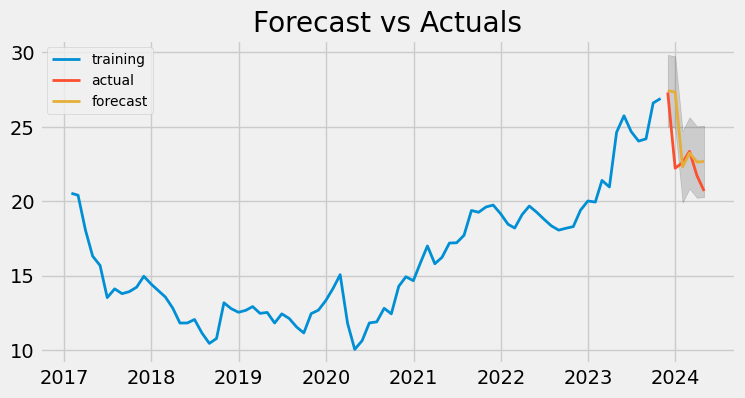

In [36]:
grafico_actual_vs_forecast(train, test, forecast_mean_3, forecast_ci_3)

Considerando toda la serie para el modelamiento, se observa que los valores predichos se acercan a los valores reales en los últimos seis meses. Se procede ahora a analizar los residuales.

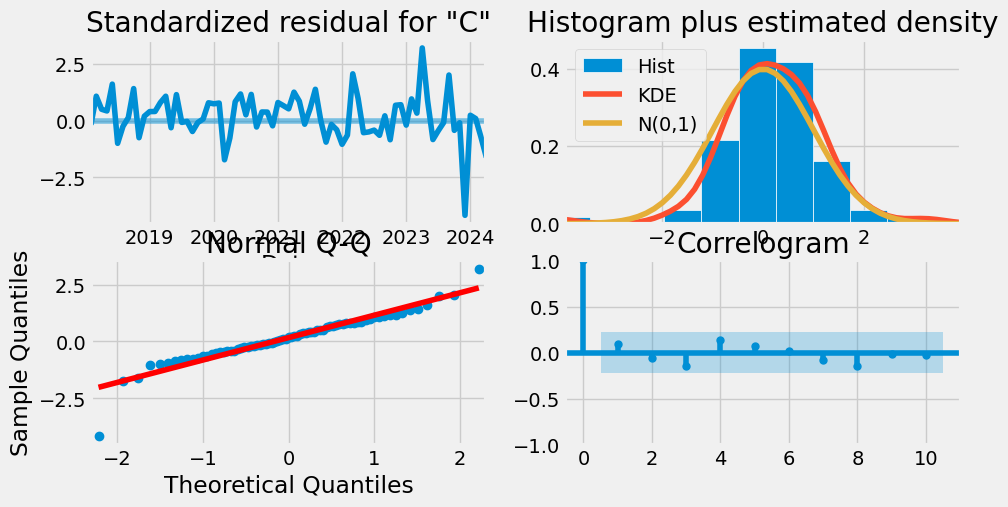

In [37]:
#Análisis de los residuos del modelo
smodel3.plot_diagnostics(figsize=(10,5))
plt.show()

##### Los errores residuales fluctuan alrededor de la media = 0.
##### La gráfica de densidad se asemeja a una normal con media = 0, aunque en el gráfico Normal Q-Q hay un par de valores extremos que se alejan mucho de la recta, por lo que los residuos podrían no seguir una distribución normal.
##### Casi todos los puntos están pegados a la linea, por lo que no hay una desviación fuerte a considerar.
##### Los errores residuales no están correlacionados.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


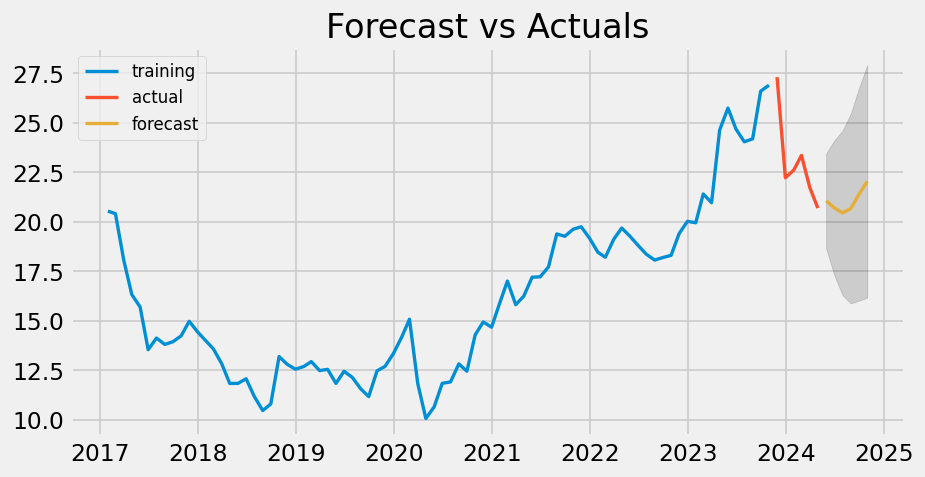

In [25]:
### Grafico de pronístico de próximos 6 meses

#fc = smodel3.forecast(6, alpha=0.05)  # 95% conf
next_6_month = smodel3.get_forecast(steps=6, alpha=0.05)# 95% conf
fc_mean = next_6_month.predicted_mean
fc_ci = next_6_month.conf_int()
grafico_actual_vs_forecast(train, test, fc_mean, fc_ci)

In [200]:
fc_mean

2024-05-31    21.057832
2024-06-30    20.707216
2024-07-31    20.447435
2024-08-31    20.674296
2024-09-30    21.373591
2024-10-31    22.043085
Freq: M, Name: predicted_mean, dtype: float64

Se obtiene el pronóstico de los siguientes seis meses, cuyo valor más bajo se da en julio, y el siguiente valor más bajo en agosto, por lo que en estos dos meses sería el mejor momento de compra.

In [28]:
### Métricas para evaluación de series de tiempo

from sklearn import metrics
import numpy as np

def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Resultado de evaluación de la Metrica:-')
    print(f'MSE es : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE es : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE es : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE es : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 es : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [34]:
timeseries_evaluation_metrics_func(test, forecast_mean_3)
#timeseries_evaluation_metrics_func(test, mean_bk)

Resultado de evaluación de la Metrica:-
MSE es : 5.1777295036982816
MAE es : 1.420403679776135
RMSE es : 2.2754624812767803
MAPE es : 10.82146134783845
R2 es : -0.17703306526959328



##### Dado el MAPE de 11 %, se obtiene que el modelo tiene un porcentaje de predicción del 89 % aproximadamente. Se procede ahora a evaluar el mismo modelo pero considerando una etapa de entrenamiento y una etapa de testing

In [104]:
X = monthly_price[["Close"]]
train, test = X[0:-6], X[-6:]

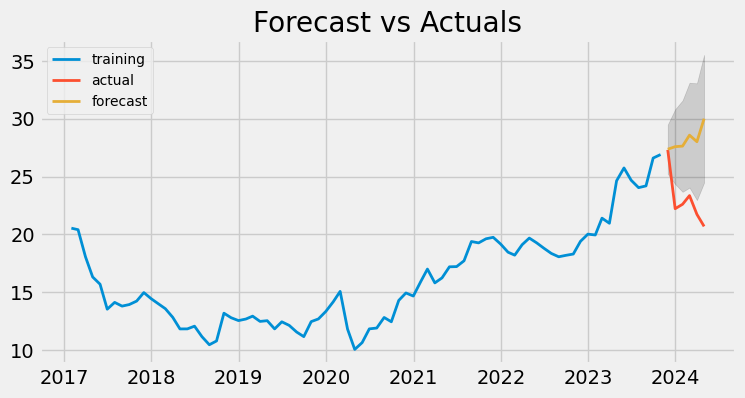

In [52]:
### Aplicando el proceso ahora considerando TRAIN y TEST
### Backtesting 6 meses antes
model_3_bk = ARIMA(train, order=(2, 1, 0), seasonal_order=(1, 1, 1, 12))
fitted3_bk = model_3_bk.fit()

# Forecast
#fc, conf = fitted3_bk.forecast(6, alpha=0.05, return_conf_int=True)  # 95% conf

n_periods = 6
fc_bk= fitted3_bk.get_forecast(steps=n_periods, alpha=0.05)
mean_bk = fc_bk.predicted_mean
ci_bk = fc_bk.conf_int()

print(fc_bk)
print(ci_bk)

# Make as pandas series
fc_series = pd.Series(fc_bk, test.index)
#lower_series = pd.Series(ci_bk[:, 0] , test.index)
#upper_series = pd.Series(ci_bk[:, 1] , test.index)

grafico_actual_vs_forecast(train, test, mean_bk, ci_bk)

In [142]:
timeseries_evaluation_metrics_func(test, mean_bk)

Resultado de evaluación de la Metrica:-
MSE es : 34.60175772518128
MAE es : 5.212433463554144
RMSE es : 5.882325877166385
MAPE es : 23.610270870633215
R2 es : -6.865882705903371



Cambiando el enfoque de aplicación, los resultados se descalibran, se procede a aplicar los métodos aplicados solo a la base de train

In [132]:
# Seasonal - fit stepwise auto-ARIMA
smodel_train1 = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=6,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel_train1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=242.996, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=239.631, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=241.501, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=241.154, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=238.095, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=241.627, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=241.628, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=241.906, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=239.508, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=239.168, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=241.022, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[6]          
Total fit time: 2.402 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -118.048
Date:                Mon, 06 May 2024   AIC                            238.095
Time:                        03:31:46   BIC                            240.490
Sample:                    01-31-2017   HQIC                           239.056
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0799      0.119      9.096      0.000       0.847       1.313
===================================================================================
Ljung-Box (L1) (Q):                   2.20   Jarque-Bera (JB):                14.71
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.11
Prob(H) (two-sided):                  0.52   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
# Seasonal - fit stepwise auto-ARIMA
smodel_train2 = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel_train2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=238.463, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=239.631, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=236.710, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=236.664, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=238.095, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=239.168, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=238.423, Time=0.95 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=238.509, Time=0.83 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=236.423, Time=0.26 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=238.423, Time=0.68 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=240.417, Time=2.98 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=236.574, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=238.217, Time=0.45 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=238.174, Time=0.35 sec
 ARIMA(1,1,2)(1,0,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -114.320
Date:                             Mon, 06 May 2024   AIC                            234.640
Time:                                     03:30:07   BIC                            241.823
Sample:                                 01-31-2017   HQIC                           237.522
                                      - 10-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1755      0.123      1.422      0.155      -0.066       0.417
ar.S.L12       0.2920      0.181      1.610      0.107      -0.063       0.647
sigma2         0.9717      0.123      7.915      0.000       0.731       1.212
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                23.13
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.16
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [171]:
# Seasonal - fit stepwise auto-ARIMA
smodel_train3 = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=3,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(smodel_train3.summary())

fitted_train_3, confint_train_3 = smodel_train3.predict(n_periods=n_periods, return_conf_int=True)
print(timeseries_evaluation_metrics_func(test, fitted_train_3))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[3] intercept   : AIC=243.006, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=239.631, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=241.508, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=241.168, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=238.095, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[3] intercept   : AIC=241.630, Time=0.17 sec
 ARIMA(0,1,0)(0,0,1)[3] intercept   : AIC=241.630, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[3] intercept   : AIC=242.662, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[3] intercept   : AIC=239.508, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept   : AIC=239.168, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=241.022, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[3]          
Total fit time: 2.516 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model: 

In [168]:
### Mejor modelo SARIMA
smodel_train_4 = ARIMA(train["Close"], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
smodel_train_4 = smodel_train_4.fit()
print(smodel_train_4.summary())

forecast_model4 = smodel_train_4.get_forecast(steps=6, alpha=0.05)
forecast_mean_4 = forecast_model4.predicted_mean
print(timeseries_evaluation_metrics_func(test, forecast_mean_4))

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   82
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -106.377
Date:                            Mon, 06 May 2024   AIC                            216.754
Time:                                    04:03:32   BIC                            221.223
Sample:                                01-31-2017   HQIC                           218.527
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.4551      0.142     -3.205      0.001      -0.733      -0.177
sigma2         1.2277      0.194   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [167]:
### Modelo 5
smodel_train_5 = ARIMA(train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
smodel_train_5 = smodel_train_5.fit()
print(smodel_train_5.summary())

forecast_model5 = smodel_train_5.get_forecast(steps=6, alpha=0.05)
forecast_mean_5 = forecast_model5.predicted_mean
print(timeseries_evaluation_metrics_func(test, forecast_mean_5))

                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                   82
Model:             ARIMA(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -105.413
Date:                          Mon, 06 May 2024   AIC                            218.827
Time:                                  04:02:52   BIC                            227.763
Sample:                              01-31-2017   HQIC                           222.372
                                   - 10-31-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1618      0.165      0.979      0.328      -0.162       0.486
ar.S.L12       0.2333      0.383      0.609      0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Considerando la etapa de entrenamiento, el mejor modelo ha sido Best model:  ARIMA(0,1,0)(0,1,1)[12]. Se procede a predecir y comparar los resultados con el testing

In [172]:
### Modelo 6
smodel_train_6 = ARIMA(train, order=(1, 1, 0), seasonal_order=(1, 0, 1, 12))
smodel_train_6 = smodel_train_6.fit()
print(smodel_train_6.summary())

forecast_model6 = smodel_train_6.get_forecast(steps=6, alpha=0.05)
forecast_mean_6 = forecast_model6.predicted_mean
print(timeseries_evaluation_metrics_func(test, forecast_mean_6))

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   82
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -114.462
Date:                            Mon, 06 May 2024   AIC                            236.925
Time:                                    04:10:21   BIC                            246.503
Sample:                                01-31-2017   HQIC                           240.767
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.122      1.255      0.209      -0.086       0.391
ar.S.L12       0.3072      0.476   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [31]:
### Modelo 7
smodel_train_7 = ARIMA(train, order=(0, 0, 1), seasonal_order=(1, 1, 2, 12))
smodel_train_7 = smodel_train_7.fit()
print(smodel_train_7.summary())

forecast_model7 = smodel_train_7.get_forecast(steps=6, alpha=0.05)
forecast_mean_7 = forecast_model7.predicted_mean
print(timeseries_evaluation_metrics_func(test, forecast_mean_7))
print(forecast_mean_7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                       SARIMAX Results                                       
Dep. Variable:                                 Close   No. Observations:                   82
Model:             ARIMA(0, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -150.580
Date:                               Mon, 06 May 2024   AIC                            311.160
Time:                                       17:01:01   BIC                            322.403
Sample:                                   01-31-2017   HQIC                           315.626
                                        - 10-31-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8090      0.084      9.674      0.000       0.645       0.973
ar.S.L12   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


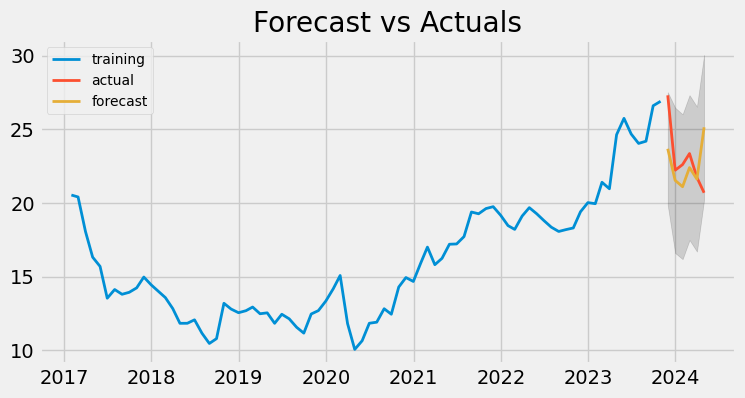

In [197]:
ci_model7 = forecast_model7.conf_int()
grafico_actual_vs_forecast(train, test, forecast_mean_7, ci_model7)

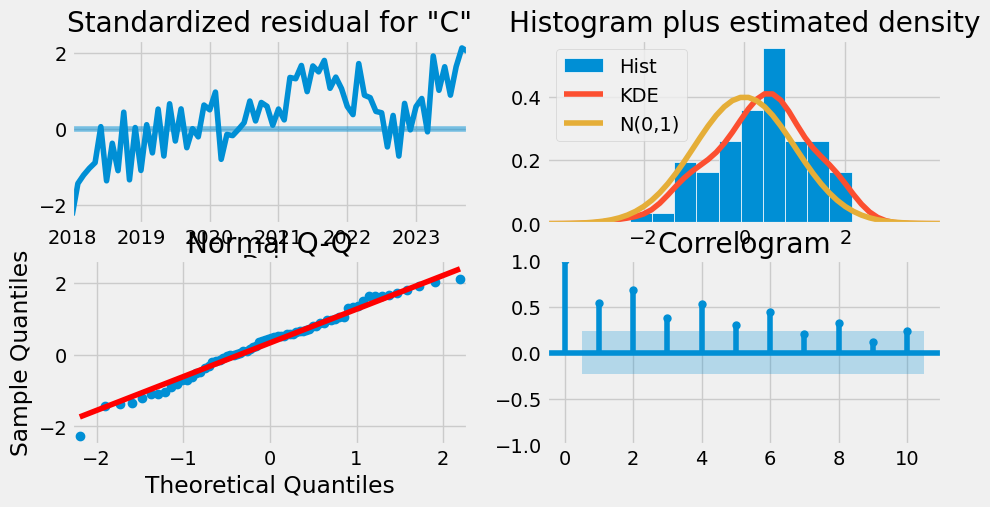

In [194]:
#Análisis de los residuos del modelo
smodel_train_7.plot_diagnostics(figsize=(10,5))
plt.show()

El modelo smodel_train_7 es el que mejor performance tiene en base a métricas de error, con un MAPE de 8.2 %. Sin embargo, existe una probable autocorrelación en los residuos a considerar

In [199]:
# Se realiza el pronóstico de los próximos 6 meses
smodel_train_7.get_forecast(steps=12, alpha=0.05).predicted_mean

2023-11-30    23.679615
2023-12-31    21.532702
2024-01-31    21.101859
2024-02-29    22.400977
2024-03-31    21.617638
2024-04-30    25.137547
2024-05-31    25.715618
2024-06-30    24.614216
2024-07-31    23.650568
2024-08-31    22.926618
2024-09-30    25.623100
2024-10-31    26.048780
Freq: M, Name: predicted_mean, dtype: float64

Se concluye que el mejor momento para hacer la compra en los próximos 6 meses es en el mes de agosto. Del próximo pronóstico, julio y agosto presentan los precios más bajos del mercado.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Resultado de evaluación de la Metrica:-
MSE es : 35.53248125304456
MAE es : 5.386733545365125
RMSE es : 5.960912786901395
MAPE es : 21.09549944839318
R2 es : -26.944731389405423

None
2023-05-31    24.088874
2023-06-30    20.494254
2023-07-31    20.137239
2023-08-31    18.802815
2023-09-30    18.731369
2023-10-31    17.594494
Freq: M, Name: predicted_mean, dtype: float64


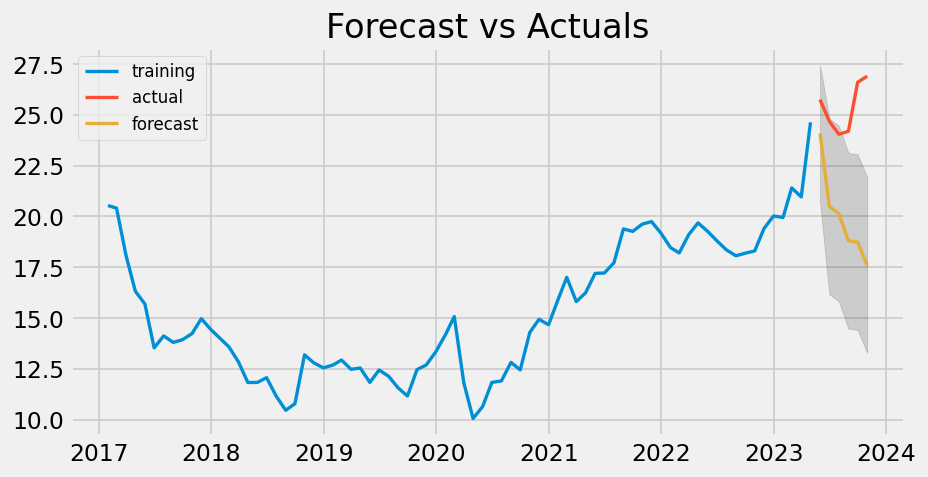

In [33]:
### Se prueba modelo en otras ventanas de tiempo

X = monthly_price[["Close"]]
train2, test2 = X[0:-12], X[-12:]
test2=test2[0:6]

model_ventana_2 = ARIMA(train2, order=(0, 0, 1), seasonal_order=(1, 1, 2, 12)).fit()

forecast_train_2 = model_ventana_2.get_forecast(steps=6, alpha=0.05)
forecast_mean_ventana_2 = forecast_train_2.predicted_mean
print(timeseries_evaluation_metrics_func(test2, forecast_mean_ventana_2))
print(forecast_mean_ventana_2)

ci_ventana_2= forecast_train_2.conf_int()
grafico_actual_vs_forecast(train2, test2, forecast_mean_ventana_2, ci_ventana_2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Resultado de evaluación de la Metrica:-
MSE es : 9.544426515435342
MAE es : 2.4761286100914326
RMSE es : 3.089405527837895
MAPE es : 11.2104977224363
R2 es : -2.187393784607118

None
2022-11-30    18.638550
2022-12-31    19.154514
2023-01-31    18.530846
2023-02-28    18.109227
2023-03-31    18.547490
2023-04-30    18.530132
Freq: M, Name: predicted_mean, dtype: float64


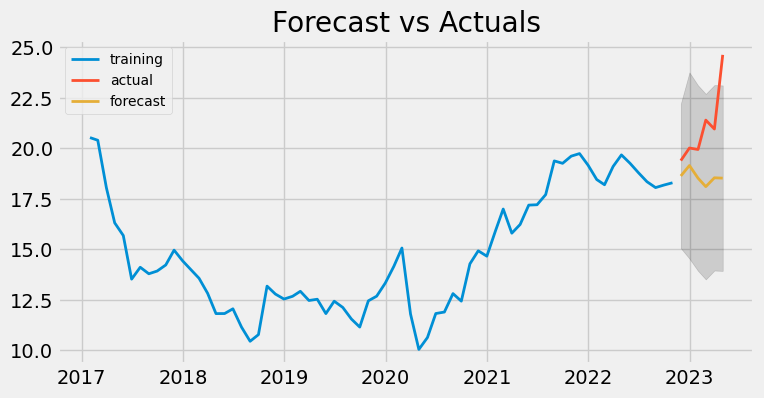

In [216]:
### Se prueba modelo en otras ventanas de tiempo

X = monthly_price[["Close"]]
train3, test3 = X[0:-18], X[-18:]
test3=test3[0:6]

model_ventana_3 = ARIMA(train3, order=(0, 0, 1), seasonal_order=(1, 1, 2, 12)).fit()

forecast_train_3 = model_ventana_3.get_forecast(steps=6, alpha=0.05)
forecast_mean_ventana_3 = forecast_train_3.predicted_mean
print(timeseries_evaluation_metrics_func(test3, forecast_mean_ventana_3))
print(forecast_mean_ventana_3)

ci_ventana3 = forecast_train_3.conf_int()
grafico_actual_vs_forecast(train3, test3, forecast_mean_ventana_3, ci_ventana3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Resultado de evaluación de la Metrica:-
MSE es : 0.12195371959175476
MAE es : 0.29848086519905276
RMSE es : 0.3492187274356213
MAPE es : 2.3571700267294937
R2 es : 0.28783156840623547

None
2022-05-31    20.013140
2022-06-30    19.376885
2022-07-31    19.615789
2022-08-31    21.923428
2022-09-30    22.326657
2022-10-31    22.992592
Freq: M, Name: predicted_mean, dtype: float64


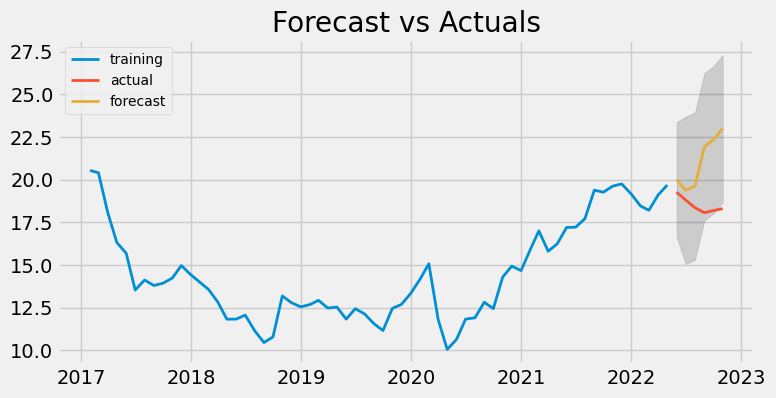

In [217]:
### Se prueba modelo en otras ventanas de tiempo

X = monthly_price[["Close"]]
train4, test4 = X[0:-24], X[-24:]
test4=test4[0:6]

model_ventana_4 = ARIMA(train4, order=(0, 0, 1), seasonal_order=(1, 1, 2, 12)).fit()

forecast_train_4 = model_ventana_4.get_forecast(steps=6, alpha=0.05)
forecast_mean_ventana_4 = forecast_train_4.predicted_mean
print(timeseries_evaluation_metrics_func(test4, forecast_mean_ventana_3))
print(forecast_mean_ventana_4)

ci_ventana4 = forecast_train_4.conf_int()
grafico_actual_vs_forecast(train4, test4, forecast_mean_ventana_4, ci_ventana4)

En la primera ventana de tiempo evaluada existe una descalibración del pronóstico. Se recomienda analizar a qué se debe esta diferencia y evaluar la posibilidad de incluir una variable exógena en el modelo.